In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="NVDA"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_cci = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')

In [4]:
# Reference: https://www.fmlabs.com/reference/default.htm?url=CCI.htm
period = 14
constant = 0.015

# Calculate Typical Price (TP)
df_cci['tp'] = (df_cci['val_high'] + df_cci['val_low'] + df_cci['val_close']) / 3

# Calculate ATP (Simple Moving Average of TP)
df_cci['atp'] = df_cci['tp'].rolling(window=period).mean()

# Calculate Mean Deviation (MD)
df_cci['dev'] = abs(df_cci['tp'] - df_cci['atp'])
df_cci['md'] = df_cci['dev'].rolling(window=period).mean()

# Calculate CCI
df_cci['cci'] = (df_cci['tp'] - df_cci['atp']) / (constant * df_cci['md'])

# Drop NaN rows (due to rolling windows)
df_cci.dropna(inplace=True)

In [5]:
df_cci.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,tp,atp,dev,md,cci
date_reference,,,,,,,,,,,
2025-10-17,NVDA,183.22,184.100,179.7500,180.180,173135217,182.356667,185.907140,3.550474,5.611243,-42.182856
2025-10-20,NVDA,182.64,185.200,181.7300,183.130,128544711,183.190000,185.768093,2.578093,5.276133,-32.575536
2025-10-21,NVDA,181.16,182.785,179.8000,182.785,124240168,181.248333,185.398212,4.149879,5.004262,-55.284585
2025-10-22,NVDA,180.28,183.440,176.7600,181.140,162249552,180.160000,184.742974,4.582974,4.615462,-66.197404
2025-10-23,NVDA,182.16,183.030,179.7901,180.420,111363718,181.660033,184.305357,2.645324,4.253581,-41.460345


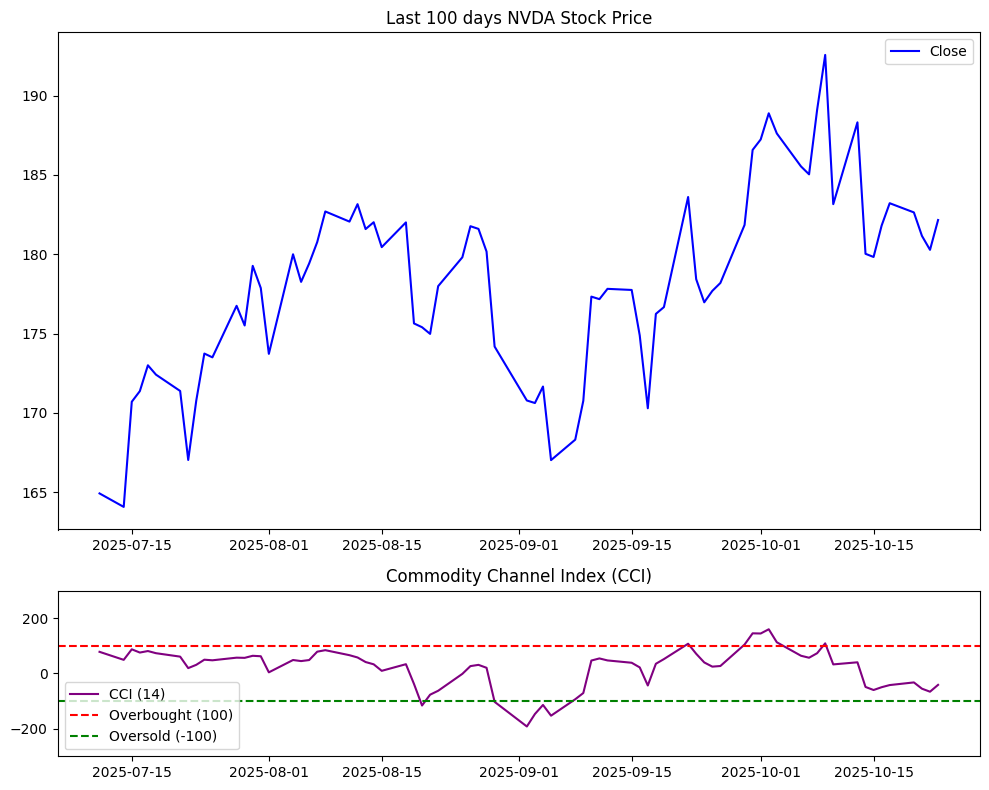

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_cci.index, df_cci['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: CCI plot
axs[1].plot(df_cci.index, df_cci['cci'], label=f"CCI ({period})", color='purple')
axs[1].axhline(100, color='red', linestyle='--', label='Overbought (100)')
axs[1].axhline(-100, color='green', linestyle='--', label='Oversold (-100)')
axs[1].set_title('Commodity Channel Index (CCI)')
axs[1].legend()
axs[1].set_ylim(-300, 300)  # Adjust for typical CCI range visibility

plt.tight_layout()
plt.show()

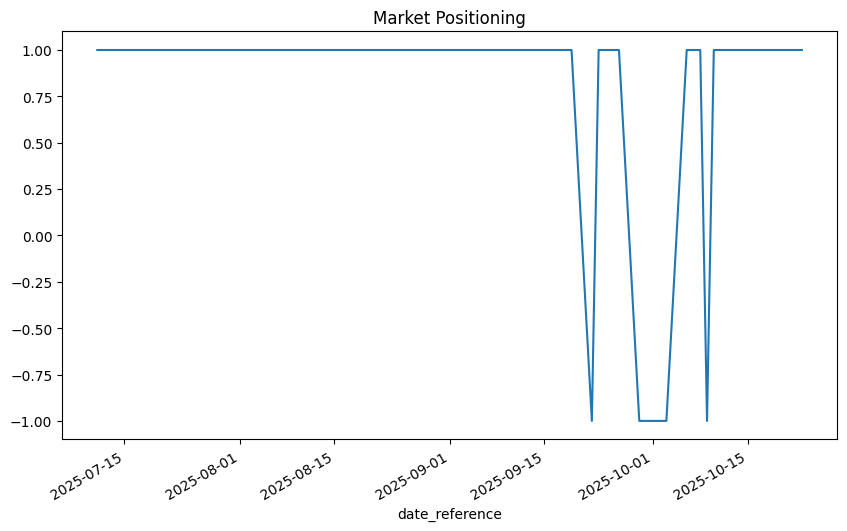

In [7]:
df_cci['position'] = np.where(df_cci['cci'] < -100, 1, np.where(df_cci['cci'] > 100, -1, 1))
df_cci['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [8]:
df_cci['returns'] = np.log(df_cci['val_close'] / df_cci['val_close'].shift(1))
df_cci['strategy'] = df_cci['position'].shift(1) * df_cci['returns']
df_cci[['returns', 'strategy']].sum().apply(np.exp)

returns     1.104536
strategy    1.241950
dtype: float64

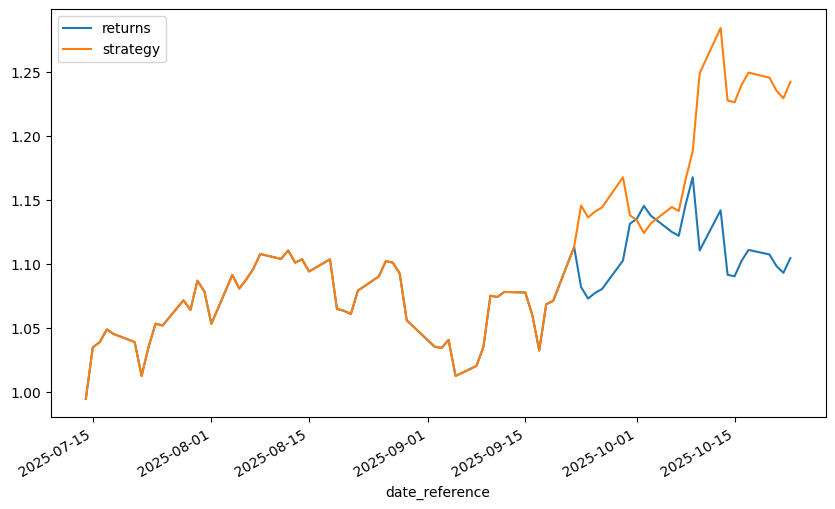

In [9]:
df_cci[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [10]:
df_cci['prev_cci'] = df_cci['cci'].shift(1)
crossovers = df_cci[
    ((df_cci['cci'] > 100) & (df_cci['prev_cci'] <= 100)) |  # Enter overbought (sell signal)
    ((df_cci['cci'] < -100) & (df_cci['prev_cci'] >= -100))  # Enter oversold (buy signal)
]
print(crossovers[['val_close', 'cci', 'position']])

                val_close         cci  position
date_reference                                 
2025-08-20         175.40 -116.175870         1
2025-08-29         174.18 -102.968933         1
2025-09-22         183.61  107.472095        -1
2025-09-29         181.85  104.464958        -1
2025-10-09         192.57  108.840734        -1
